In [3]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from functools import partial
from scipy import special as sp
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import integrate
%config InlineBackend.figure_format = 'svg'
#%matplotlib notebook

In [137]:
tem = 1
L = 60
vmax = 15  # 10 * np.sqrt(tem)
nx = 101
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.005
max_steps  = 500000
data_steps = 10000
data_num = int(max_steps/data_steps)
uai = 0.6
uae = 0.4

path = './data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

data_num =  50


In [123]:
k = 2*np.pi/L
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
#kvec = np.arange(.1,1.2,0.1)
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("rt = ", abs(s.x[1]/np.sqrt(abs(uae-uai))))
print("1/r = ", abs(1/s.x[1]))
print('ltime',2*np.pi/k/dv)
print('rtime = ', max_steps*dt)

k =  0.10471975511965977
w_r =  1.0166881683632336
w_i =  -1.6007897698337926e-13
v_p =  9.708656854683225
rt =  3.5794747430346027e-13
1/r =  6246916483629.38
ltime 2000.0
rtime =  1250.0


## 理论预测

In [61]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r

In [62]:
#theoretical energy
def nphi(x):
    phi = -( n*q*(uae-uai) )/ (k**2)*np.cos(k*x)/L
    return (ui(x)-ue(x) )*q*phi
ek_theo = 0.5*tem
ep_theo = 0.5*integrate.quad(nphi,0,L)[0]
einit_theo=ek_theo+ep_theo

print("Ek = ",ek_theo)
print("Ep = ",ep_theo)
print("Etot = ",einit_theo)

Ek =  0.5
Ep =  0.9118906527810398
Etot =  1.4118906527810398


In [63]:
def entropy(x,v):
    ufv = fm(v, tem)*ue(x)/L
    if (ufv==0.0):
        r = 0.0
    else:
        r = -ufv * np.log(ufv)
    return r
options = {'limit':50000}
entropyt_int_res = integrate.nquad(entropy,[[0,L],[-np.inf,np.inf]], opts=[options,options])
entropyt=entropyt_int_res[0]
print(entropyt)

5.472436909879605


In [64]:
def ug(x):
    r = (1. + uai * np.cos(k*x)) #/ (2*1.*a)
    return r

def ug_dev(x):
    r = -uai*k*np.sin(k*x)#/ 2. / a
    return r

def eq4U(x,yy,p):
    kappa,t=p
    dy, y = yy
    k_factor = (kappa+2) / (kappa+1)
    dy2y = (dy**2) / y
    ddy = k_factor * dy2y + (kappa+1) / (kappa) * (y**k_factor) * ( y-ui(x) ) / t * n * (q**2)
    return np.vstack((ddy, dy))

def bc4U(ya, yb):
    return np.array([ya[0]-yb[0],ya[1]-yb[1]])

xi = np.linspace(0, L, num=5000, dtype='complex',endpoint=False)
yguess = np.array([ug_dev(xi), ui(xi)])

def eq4para(x,energy,entropy):
    kp,tp = x
    sol4ode = solve_bvp(partial(eq4U, p=x), bc4U, xi,
                        yguess, tol=1e-13, max_nodes=50000)

    def ff(x):
        return sol4ode.sol(x)[1]
    def ff_r(x):
        return ff(x).real
    def ff_i(x):
        return ff(x).imag

    def ff_inti(x):
        r = ff(x)**(kp/(kp+1))
        return r
    def ff_inti_r(x):
        return ff_inti(x).real
    def ff_inti_i(x):
        return ff_inti(x).imag
        
    def ff_intii(x):
        r = ui(x) * (ff(x) ** (-1.0/(kp+1)))
        return r
    def ff_intii_r(x):
        return ff_intii(x).real
    def ff_intii_i(x):
        return ff_intii(x).imag
    
    def ff_intiii(x):
        r = ff(x)**(-1./(kp+1))
        return r
    def ff_intiii_r(x):
        return ff_intiii(x).real
    def ff_intiii_i(x):
        return ff_intiii(x).imag
    
    def entropy_pred(x, v):
        U_x = ff(x)
        
        if(kp==0):
            t_x = tp
            tempf = U_x * fm(v, t_x)+0j
        else:
            t_x = tp * U_x ** (-1./(kp+1))
            tempf = U_x * fk(v, t_x, kp)/L+0j
        if (tempf == 0.0+0.0j):
            r = 0.0
        else:
            r = -tempf * np.log(tempf)
        r = -tempf * np.log(tempf)
        return r
    def entropy_pred_r(x,v):
        return entropy_pred(x,v).real
    def entropy_pred_i(x,v):
        return entropy_pred(x,v).imag
    entropy_pred_int_r = integrate.dblquad(
        entropy_pred_r, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropy_pred_int_i = integrate.dblquad(
        entropy_pred_i, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropyp = entropy_pred_int_r[0] + 1j * entropy_pred_int_i[0]

    int_ff_r = integrate.quad(ff_r, 0, L, epsrel=1e-10)[0]-1.0
    int_ff_i = integrate.quad(ff_i, 0, L, epsrel=1e-10)[0]-1.0
    int_ff = int_ff_r + 1j * int_ff_i
    
    int_i_r = integrate.quad(ff_inti_r, 0, L, epsrel=1e-10)[0]
    int_i_i = integrate.quad(ff_inti_i, 0, L, epsrel=1e-10)[0]
    int_i = int_i_r + 1j * int_i_i

    int_ii_r = integrate.quad(ff_intii_r, 0, L, epsrel=1e-10)[0]
    int_ii_i = integrate.quad(ff_intii_i, 0, L, epsrel=1e-10)[0]
    int_ii = int_ii_r + 1j * int_ii_i

    int_iii_r = integrate.quad(ff_intiii_r, 0, L, epsrel=1e-10)[0]
    int_iii_i = integrate.quad(ff_intiii_i, 0, L, epsrel=1e-10)[0] 
    int_iii = (int_iii_r + 1j * int_iii_i) * int_ff

    eq1 = ((energy*2)*L - tp * (1+kp) * int_i + tp * kp * int_ii)/(energy*2)/L
    eq2 = (entropyp-entropy)/entropy

    return eq1.real,eq2.real

In [65]:
para_guess = [0.14708099,2.83689694]# initial guess of parameters
#para_guess = [0,1]# initial guess of parameters
sol_para = op.root(partial(eq4para,energy=einit_theo,entropy=entropyt), para_guess, method='hybr')
para = sol_para.x

print(para)
print(sol_para.fun,sol_para.success)

[0.20782554 2.86370909]
[-3.94217363e-15 -4.23603911e-14] True


## 模拟结果

In [138]:
progesses = np.arange(0,data_num,1)

f = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)

In [139]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

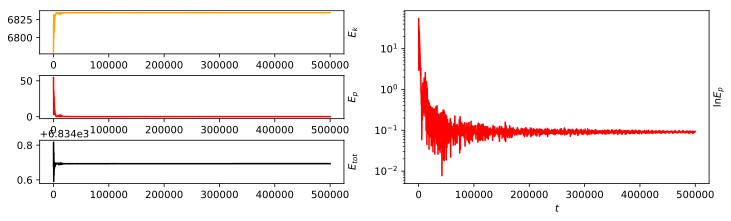

In [140]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

### 初始分布函数fx fv

In [141]:
fx0 = np.sum(f[0][:,0:nv-1],axis=1)*dv
fv0 = np.sum(f[0][0:nx-1,:],axis=0)*dx

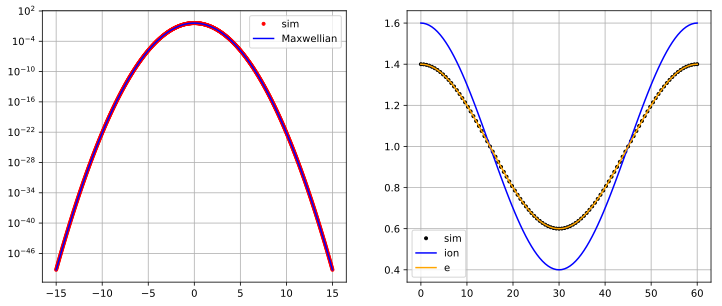

In [142]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v,fv0,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x,fx0,'.',color='black',label='sim')
ax2.plot(x,ui(x),color='blue',label='ion')
ax2.plot(x,ue(x),color='orange',label='e')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 末态分布函数

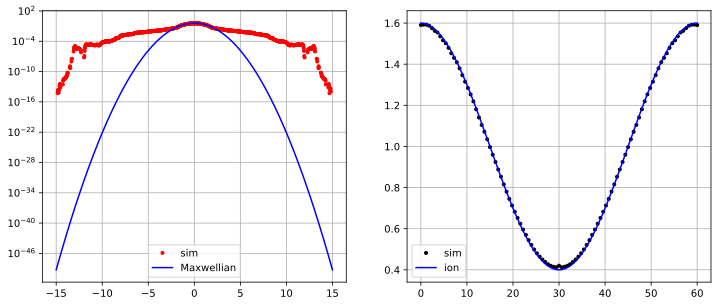

In [143]:
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v,fv,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x,fx,'.',color='black',label='sim')
ax2.plot(x,ui(x),color='blue',label='ion')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

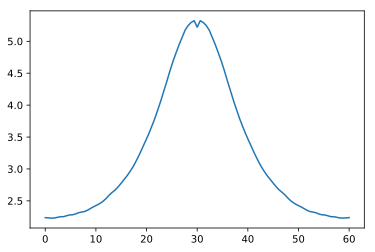

In [144]:
Z = f[data_num-1]
fz = np.sum(Z,axis=1)*dv
vv = v
T = np.sum(vv**2*Z,axis=1)*dv/fz
plt.plot(x,T)
plt.show()

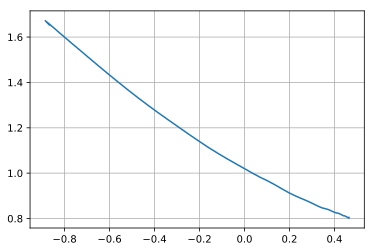

In [145]:
plt.plot(np.log(fz),np.log(T))
plt.grid()
plt.show()

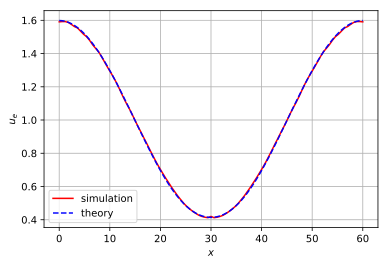

0.0015519592680598214


In [146]:
#para = [0.98491281,T.mean()]
yguess = np.array([ug_dev(x), ui(x)])
sol = solve_bvp(partial(eq4U,p=para), bc4U, x, yguess,tol=1e-13,max_nodes=50000)
def ff(x):
    return sol.sol(x)[1].real
ax1 = plt.gca()#subplot2grid((1, 2), (0, 0))

ax1.plot(x,fx,'-',color='r',label=r'simulation')
ax1.plot(x,ff(x),'--',label=r'theory',color='blue')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u_e$')

ax1.legend()
ax1.grid()

plt.show()
chi_err_u = np.sum( ( fx-ff(x) )**2/ff(x) ) * dx
print(chi_err_u)

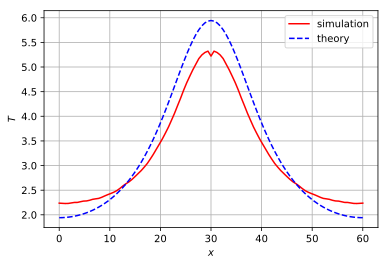

2.0349272800051894


In [147]:
def t_theo(x):
    return para[1]*(ff(x).real)**(-1.0/(para[0]+1))

plt.plot(x, T,'-',color='r',label='simulation')
plt.plot(x,t_theo(x), '--',color='blue', label = 'theory')
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')
plt.legend()
plt.grid()
plt.show()
chi_err_t = np.sum( ( T-t_theo(x) )**2/t_theo(x) ) * dx
print(chi_err_t)

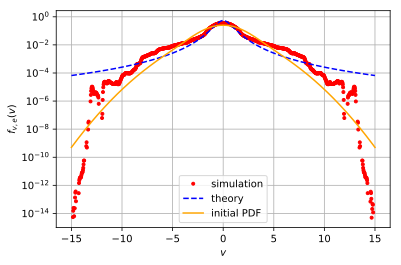

In [148]:
def fk_xv(x,v,k,t):
    if(k==0):
        s = ff(x)*np.sqrt( ff(x)**( 1./(k+1) ) / (2*np.pi*t) )/L
        m = np.exp(-v**2 / (2*t) * ff(x)**(1./(k+1)))
        r = s*m
    else:
        s = ff(x)*np.sqrt( ff(x)**( 1./(k+1) ) / (2*np.pi*t*k) )/L
        frac = sp.gamma(k+1.5) / sp.gamma(k+1)
        m = ( 1+ (v)**2 / (k*2*t) * ff(x)**(1./(k+1)) )**(-k-1.5)
        r = s*frac*m
    return r.real
def fk_v_nonvec(vv,kk,tt):
    r = integrate.quad(partial(fk_xv,v=vv,k=kk,t=tt),0,L)[0]*n
    return r
fk_v = np.vectorize(fk_v_nonvec)

ax1 = plt.gca()

ax1.plot(v, fv, '.', color='r', label='simulation')
ax1.plot(v, fk_v(v, para[0],para[1]),'--',color='blue',label='theory')
#ax1.plot(v, fm(v, tem),color='orange',label='initial PDF')
ax1.plot(v, fk_v(v, 0,para[1]),color='orange',label='initial PDF')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_{v,e}(v)$')

ax1.legend()
ax1.grid()
ax1.set_yscale('log')
plt.show()

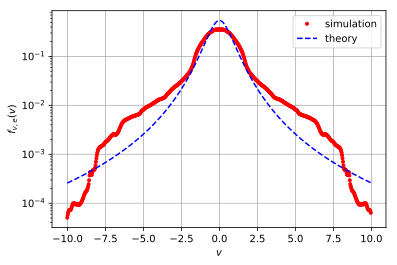

In [149]:
v_plot = 10
v_min = int((-v_plot + vmax)/dv)
v_max = int((v_plot + vmax)/dv)

vv = v[v_min:v_max]
ax1 = plt.gca()

ax1.plot(vv, fv[v_min:v_max], '.', color='r', label='simulation')
ax1.plot(vv, fk_v(vv, para[0],para[1]),'--',color='blue',label='theory')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_{v,e}(v)$')

ax1.legend()
ax1.grid()
ax1.set_yscale('log')
plt.show()

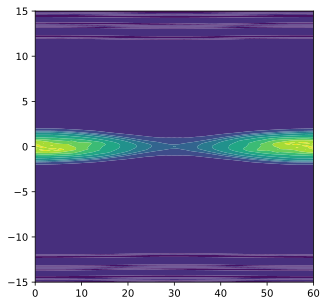

In [150]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
Z = f[data_num-1]
plt.contourf(X,V,Z,levels=10)
plt.show()